In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("Valuation_test")

LangSmith 추적을 시작합니다.
[프로젝트명]
Valuation_test


In [3]:
from typing import Annotated, TypedDict, Dict
from langgraph.graph.message import add_messages

class GraphState(TypedDict):
    question: Annotated[list, add_messages]
    context: Annotated[str, "Context"]
    answer: Annotated[str, "Answer"]
    messages: Annotated[list, add_messages]
    company: Annotated[str, "기업명"]
    sector: Annotated[str, "섹터명"]
    fcfe: Annotated[float, "FCFE 계산 결과"]
    wacc: Annotated[float, "WACC 계산 결과"]
    growth_rate_tv: Annotated[float, "Terminal Value에 사용한 성장률 계산 결과"]
    growth_rate_fcfe: Annotated[float, "5년간 FCFE에 사용한 성장률 계산 결과"]
    valuation_result: Annotated[Dict[str, float], "회사 가치 계산 결과"]

In [4]:
from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_teddynote.models import get_model_name, LLMs

# 최신 LLM 모델 이름 가져오기
MODEL_NAME = "gpt-4o-mini"


# 사용자 쿼리를 가장 관련성 높은 데이터 소스로 라우팅하는 데이터 모델
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    # 데이터 소스 선택을 위한 리터럴 타입 필드
    datasource: Literal["valuation_calculator", "llm"] = Field(
        ...,
        description=(
            "Given a user question, choose to route it to either the Valuation Calculator "
            "or to the Large Language Model (LLM)."
        ),
    )


# LLM 초기화 및 함수 호출을 통한 구조화된 출력 생성
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)
structured_llm_router = llm.with_structured_output(RouteQuery)

# 시스템 메시지와 사용자 질문을 포함한 프롬프트 템플릿 생성
system = """
당신은 사용자 질문을 적절한 데이터 소스로 라우팅하는 역할을 맡은 라우터입니다. 다음 지침을 따라 사용자 질문을 처리하세요:

1. **주가 예측 관련 질문:**
   - 사용자가 "주가 예측", "주가가 어떻게 될 것 같은지", "주식 가격 전망" 등과 같은 주가 예측과 관련된 질문을 할 경우, 해당 질문을 **Valuation Calculator**으로 라우팅하세요.

2. **기타 질문:**
   - 사용자가 주가 예측과 관련되지 않은 다른 주제에 대한 질문을 할 경우, 해당 질문을 **Large Language Model (LLM)**으로 라우팅하세요.

**예시:**
- **사용자 질문:** "다음 달 애플의 주가는 어떻게 될 것 같아?"
  - **라우팅 대상:** Valuation Calculator

- **사용자 질문:** "오늘 날씨가 어때?"
  - **라우팅 대상:** Large Language Model (LLM)

- **사용자 질문:** "비트코인 가격 예측해줘."
  - **라우팅 대상:** Valuation Calculator

- **사용자 질문:** "좋은 레스토랑 추천해줘."
  - **라우팅 대상:** Large Language Model (LLM)

**주가 예측 관련 키워드:**
- 주가 예측
- 주가 전망
- 주식 가격 예측
- 주가 상승/하락 예측
"""

# Routing 을 위한 프롬프트 템플릿 생성
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

# 프롬프트 템플릿과 구조화된 LLM 라우터를 결합하여 질문 라우터 생성
question_router = route_prompt | structured_llm_router

In [5]:
def route_question(state : GraphState) -> str:
    print("==== [ROUTE QUESTION] ====")
    # 질문 가져오기
    question = state["question"]
    # 질문 라우팅
    source = question_router.invoke({"question": question})
    # 질문 라우팅 결과에 따른 노드 라우팅
    if source.datasource == "valuation_calculator":
        print("==== [ROUTE QUESTION TO VALUATION CALCULATOR] ====")
        return "valuation_calculator"
    elif source.datasource == "llm":
        print("==== [ROUTE QUESTION TO LLM] ====")
        return "llm"

In [6]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

find_sector_and_company_prompt = PromptTemplate(
    template = """
역할:
당신은 베테랑 프롬프트 엔지니어로, 대형 언어 모델(LLM)이 최상의 성능을 발휘할 수 있도록 프롬프트를 최적화하는 데 능숙합니다.

작업:
주어진 질문에서 언급된 회사명과 섹터를 각각 추출하여 다음 형식으로 출력하십시오.

출력 형식:
	•	회사명,섹터 형태로 응답하십시오.
	•	회사명과 섹터 이외의 정보는 포함하지 마십시오.
	•	따옴표(””)는 반드시 포함하지 말고 출력하십시오.

예시:

입력:

"1. DB하이텍의 공정 PER을 계산하기 위해 반도체 산업 내 유사 기업들의 성장률과 PER을 분석하라."

출력:

DB하이텍,반도체

입력:

"1. 삼성전자의 PER을 계산하기 위해 반도체 산업 내 다른 기업들의 성장률과 PER을 분석하라."

출력:

삼성전자,반도체

추가 예시:

입력:

"1. 현대자동차의 시장 점유율을 평가하기 위해 자동차 산업 내 경쟁사의 판매 데이터를 분석하라."

출력:

현대자동차,자동차

입력:

"1. 네이버의 사용자 증가율을 측정하기 위해 IT 섹터 내 다른 플랫폼의 성장률과 사용자 수를 비교하라."

출력:

네이버,IT


# 다음 질문에 대해서 회사명과 섹터를 각각 추출하시오.
{question}
""",
input_variables=["question"],
)

finder_sector_and_company=(
    find_sector_and_company_prompt | ChatOpenAI(model="gpt-4o-mini", temperature=0) | StrOutputParser()    
)

In [7]:
def find_sector_and_company(state:GraphState)->GraphState:
    question=state["question"][0].content
    sector_and_company = finder_sector_and_company.invoke({"question":question})
    company, sector = sector_and_company.split(",")
    return GraphState(company=company, sector=sector)

In [8]:
from yahooquery import search
from deep_translator import GoogleTranslator
import pandas as pd

def get_ticker(company_name):
    try:
        # 사전 매핑 확인
        # if company_name in manual_mapping:
        #     return manual_mapping[company_name]
        
        # 회사명을 영어로 번역
        translated = GoogleTranslator(source='auto', target='en').translate(company_name)
        print(f"Translated company name: {translated}")
        
        # 번역된 이름으로 검색
        results = search(translated)
        if results is not None and 'quotes' in results and len(results['quotes']) > 0:
            # 첫 번째 결과의 티커 반환
            return results['quotes'][0]['symbol']
        else:
            print(f"No ticker found for {company_name} after translation.")
            return None
    except Exception as e:
        print(f"Error translating or searching for {company_name}: {e}")
        return None

In [9]:
from DCF.calculators.valuation import ValuationCalculator

def valuation_calculator(state:GraphState)->GraphState:
    ticker=get_ticker(state["company"])
    valuation_calculator=ValuationCalculator(ticker_symbol=ticker)
    dcf, fcfe, wacc, growth_rate_fcfe, growth_rate_tv = valuation_calculator.calculate_per_share()
    dcf = int(dcf)
    fcfe = int(fcfe)
    wacc = round(wacc * 100, 2)
    growth_rate_fcfe = round(growth_rate_fcfe * 100, 2)
    growth_rate_tv = round(growth_rate_tv * 100, 2)
    return GraphState(
        valuation_result={"dcf":dcf}, 
        fcfe=fcfe, 
        wacc=wacc, 
        growth_rate_fcfe=growth_rate_fcfe, 
        growth_rate_tv=growth_rate_tv
    )

In [10]:
def valuation_llm(state: GraphState) -> GraphState:
    prompt = PromptTemplate.from_template( """
        너는 금융 전문가야 아래 내용을 보고 질문에 대해 적절한 대답을 해.
        DCF 계산 결과를 언급하고 나서, DCF를 어떻게 구할 수 있었는지 과정과 그 이유를 단계별로 설명해.
        설명은 최대한 상세하게하고 Valuation 과정에 사용한 변수들과 숫자도 언급해.

        -- Valuation에 사용한 변수 --
        FCFE
        WACC: {wacc}%
        5년간 FCFE에 사용한 Growth Rate: {growth_rate_fcfe}% - 연간 성장률 사용
        Terminal Value에 사용한 Growth Rate: {growth_rate_tv}% - 성장률(1%)가정

        -- Valuation Result --
        DCF 계산 결과 주당 가치: {dcf_valuation_result}원

        -- Question --
        {question}

        """
    )
    chain = prompt | ChatOpenAI() | StrOutputParser()
    return GraphState(answer=chain.invoke({
        "question":state['question'][0].content, 
        "fcfe":state["fcfe"], 
        "wacc":state["wacc"], 
        "growth_rate_tv":state["growth_rate_tv"],
        "growth_rate_fcfe":state["growth_rate_fcfe"],
        "dcf_valuation_result":state["valuation_result"]["dcf"]
        })
    )

In [11]:
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

In [12]:
workflow = StateGraph(GraphState)

In [13]:
workflow.add_node("find_sector_and_company", find_sector_and_company)
workflow.add_node("valuation_calculator", valuation_calculator)
workflow.add_node("valuation_llm", valuation_llm)

In [14]:

workflow.add_edge("find_sector_and_company", "valuation_calculator")
workflow.add_edge("valuation_calculator", "valuation_llm")
workflow.add_edge("valuation_llm", END)

In [15]:
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "valuation_calculator": "find_sector_and_company",
        "llm": "valuation_llm",
    }
)

In [16]:
memory = MemorySaver()
# 그래프 컴파일
app = workflow.compile(checkpointer=memory)

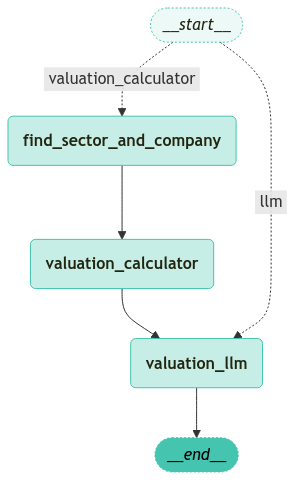

In [17]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)

In [18]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = GraphState(question="SK하이닉스의 주가가 어떻게 될것 같아?")

# 그래프 실행
stream_graph(app, inputs, config, [START,"route_question", "valuation_calculator", "valuation_llm",END])

==== [ROUTE QUESTION] ====

🔄 Node: __start__ 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
==== [ROUTE QUESTION TO VALUATION CALCULATOR] ====
Translated company name: SK Hynix

FCFE:
FCFE: 4,497,652,000,000
Operating Cash Flow: 3,591,547,000,000
Capital Expenditure: 7,142,229,000,000
Repayment of Debt: -9,015,663,000,000
Issuance of Debt: 17,063,997,000,000


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


WACC: 7.83%
Cost of Equity: 10.87%
Cost of Debt: 4.50%
Equity Weight: 58.65%
Debt Weight: 41.35%
Risk-free Rate: 4.23%
Market Risk Premium: 7.70%
Beta: 0.86
Effective Tax Rate: 22.00%
retention_ratio: 0.918800004
net_income: -4836170000000.0
total_equity: 54518322000000.0

성장률 계산 결과:
성장률: -8.15%

구성 요소:
Retention Ratio: 0.92
ROE: -0.09
_1year_fcfe: 4497652000000.0
_2year_fcfe: 4131074406243.3354
_3year_fcfe: 3794374431351.898
_4year_fcfe: 3485116923466.2744
_5year_fcfe: 3201065205866.759

FCFE:
FCFE: 4,497,652,000,000
Operating Cash Flow: 3,591,547,000,000
Capital Expenditure: 7,142,229,000,000
Repayment of Debt: -9,015,663,000,000
Issuance of Debt: 17,063,997,000,000


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


WACC: 7.83%
Cost of Equity: 10.87%
Cost of Debt: 4.50%
Equity Weight: 58.65%
Debt Weight: 41.35%
Risk-free Rate: 4.23%
Market Risk Premium: 7.70%
Beta: 0.86
Effective Tax Rate: 22.00%
retention_ratio: 0.918800004
net_income: -4836170000000.0
total_equity: 54518322000000.0

성장률 계산 결과:
성장률: -8.15%

구성 요소:
Retention Ratio: 0.92
ROE: -0.09
_6year_fcfe: 3233075857925.4263
terminal_value: 46186797970363.23
Total Value: 62926469310736.734
Per Share: 91380.81022109457

🔄 Node: valuation_llm 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
DCF 계산 결과에 따르면 SK하이닉스의 주당 가치는 91380원이 나왔습니다. 따라서 현재 주가와 비교해보았을 때 SK하이닉스의 주가가 이 가치에 미치지 못하거나 초과할 수 있습니다. 

DCF를 구하는 과정은 다음과 같습니다:

1. 먼저, 미래의 현금흐름을 추정하기 위해 Free Cash Flow to Equity(FCFE)를 계산합니다. FCFE는 기업이 영업활동으로 얻는 현금흐름에서 투자와 재무활동으로 인한 변화를 고려한 값입니다.

2. 다음으로, Weighted Average Cost of Capital(WACC)을 계산합니다. WACC는 기업의 자본 구조와 비용을 고려한 평균 자본 비용을 나타내는 지표입니다. 이를 통해 기업의 자본의 비용을 알 수 있습니다.

3. 5년간의 FCFE에 사용할 Growth Rate와 Terminal Value에 사용할 Growth Rate를 정합니다. 이러한 성장률

In [19]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = GraphState(question="삼성전자의 주가가 어떻게 될것 같아?")

# 그래프 실행
stream_graph(app, inputs, config, [START,"route_question", "valuation_calculator", "valuation_llm",END])

==== [ROUTE QUESTION] ====

🔄 Node: __start__ 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
==== [ROUTE QUESTION TO VALUATION CALCULATOR] ====
Translated company name: Samsung Electronics

FCFE:
FCFE: -15,116,207,000,000
Operating Cash Flow: 44,137,427,000,000
Capital Expenditure: 60,534,167,000,000
Repayment of Debt: -1,219,579,000,000
Issuance of Debt: 2,500,112,000,000


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


WACC: 8.61%
Cost of Equity: 9.90%
Cost of Debt: 4.50%
Equity Weight: 79.77%
Debt Weight: 20.23%
Risk-free Rate: 4.23%
Market Risk Premium: 7.70%
Beta: 0.74
Effective Tax Rate: 22.00%
retention_ratio: 0.6940999999999999
net_income: 14473401000000.0
total_equity: 363677865000000.0

성장률 계산 결과:
성장률: 2.76%

구성 요소:
Retention Ratio: 0.69
ROE: 0.04
_1year_fcfe: -15116207000000.0
_2year_fcfe: -14698647276928.88
_3year_fcfe: -14292621936942.832
_4year_fcfe: -13897812362163.256
_5year_fcfe: -13513908735993.062

FCFE:
FCFE: -15,116,207,000,000
Operating Cash Flow: 44,137,427,000,000
Capital Expenditure: 60,534,167,000,000
Repayment of Debt: -1,219,579,000,000
Issuance of Debt: 2,500,112,000,000


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


WACC: 8.61%
Cost of Equity: 9.90%
Cost of Debt: 4.50%
Equity Weight: 79.77%
Debt Weight: 20.23%
Risk-free Rate: 4.23%
Market Risk Premium: 7.70%
Beta: 0.74
Effective Tax Rate: 22.00%
retention_ratio: 0.6940999999999999
net_income: 14473401000000.0
total_equity: 363677865000000.0

성장률 계산 결과:
성장률: 2.76%

구성 요소:
Retention Ratio: 0.69
ROE: 0.04
_6year_fcfe: -13378769648633.13
terminal_value: 167234620607914.12
Total Value: 105909847518344.12
Per Share: 17740.996074287665

🔄 Node: valuation_llm 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
DCF (Discounted Cash Flow) 방법은 기업의 미래 현금흐름을 현재 가치로 환산하여 기업가치를 산정하는 방법론입니다. 

1. 먼저, Free Cash Flow to Equity (FCFE)를 계산합니다. FCFE는 기업이 영업활동을 통해 발생한 현금흐름 중 자본주주에게 배당될 수 있는 현금흐름을 말합니다. FCFE는 일반적으로 다음과 같이 계산됩니다:

FCFE = Operating Cash Flow - Capital Expenditures + Net Borrowing

2. 다음으로, Weighted Average Cost of Capital (WACC)를 계산합니다. WACC는 기업의 자본과 부채의 비용을 고려하여 가중평균한 것으로, 기업의 자본조달 비용을 나타냅니다. WACC는 일반적으로 다음과 같이 계산됩니다:

WACC = (E/V) * Re + (D/V) * Rd * (